In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt

from spectral_cube import SpectralCube
import astropy.units as u
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook

In [2]:
OMC2 = "/Users/jbublitz/Desktop/OMC2_ALMA_Sokar/ALMA_OMC2_Region2/2017.1.01353.S/science_goal.uid___A001_X1292_X11e/group.uid___A001_X1292_X11f/member.uid___A001_X1292_X120/product/member.uid___A001_X1292_X120.OMC-2_Region2_sci.spw25.cube.I.manual.image.pbcor.fits"

cube = SpectralCube.read(OMC2)

In [3]:
# Convert velocities into channel numbers
header = cube[0].header
crp1 = header['CRPIX1']
crp2 = header['CRPIX2']
#crp3 = header['CRPIX3']
crv1 = header['CRVAL1']
crv2 = header['CRVAL2']
#crv3 = header['CRVAL3']
cd1 = header['CDELT1']
cd2 = header['CDELT2']
#cd3 = header['CDELT3']

Finit = 2.300624955763E+11 #header['CRVAL3'] #frequency of initial channel in Hz (Channel 0)
Fres = 4.883000000000E+05 #header['CDELT3'] #spectral resolution, in Hz
Fsys = header['RESTFRQ'] # Systemic freq in header in Hz
Cvel = 3e5 #speed of light in km/s
Vinit = -Cvel*(1 - Finit/Fsys) #velocity of initial channel
Vdelt = Cvel*Fres/Fsys #Change in velocity per channel
print('Initial Vel: ','v=%4.1f km/s' %Vinit, ', Vel Change: ', 'v=%4.3f km/s' %Vdelt)

Initial Vel:  v=-618.7 km/s , Vel Change:  v=0.635 km/s


In [4]:
# DEFINING USEFUL CONVERSION FUNCTIONS

def hms(hour, mint, sec): # Converts RA hh:mm:ss into degrees
    degree = (hour + (mint + sec/60.)/60.)*360/24
    return degree

def dms(deg, mint, sec): # Converts Dec dd:mm:ss into degrees
    if deg > 0.:
        degree = deg + (mint + sec/60.)/60.
    else:
        degree = -(-deg + (mint + sec/60.)/60.)
    return degree

def Vel_to_Ch(Vin): # Takes Velocity # and converts to proper channel #
    Ch_Out = -np.int((Vin + Vinit) / Vdelt)
    return Ch_Out
def Ch_to_Vel(Ch): # Converts Channel number to Velocity
    V_out = -Ch*Vdelt - Vinit
    return V_out

V1 = Vel_to_Ch(0)
Vsys = Vel_to_Ch(11)
V2 = Vel_to_Ch(30)

def Pix_to_Angle(PixIn, axis): # Converts image pixel values to RA and Dec angles
	if axis == 'dec':
		Angle = (PixIn - crp2) * cd2 +crv2
	if axis == 'ra':
		Angle = (PixIn - crp1) * cd1 +crv1
	return Angle

def Angle_to_Pix(Angle, axis): # Converts RA or Dec value to image pixel value
	if axis == 'dec':
		PixVal = np.int(crp2 + (Angle - crv2)/cd2)
	if axis == 'ra':
		PixVal = np.int(crp1 + (Angle - crv1)/cd1)
	return PixVal

In [5]:
# DEFINING THE BOUNDS OF THE IMAGE IN RA/DEC AND PIXELS

ra_center = hms(5,35,23)	#Degrees (5h35m23s) 83.84757
dec_center = dms(-5,12,0)		#Degrees (-5:12:00)
#ra_img = 83.8542		#5:35:25
#dec_img = -5.197		#-5:11:50

rabox_min	= hms(5,35,19)	#ra_center+1.5/240.
rabox_max	= hms(5,35,28)	#ra_center-0.5/240.
decbox_min	= dms(-5,12,24)	#dec_center+1/240.
decbox_max	= dms(-5,11,30)	#dec_center+3/240.

xbox_min	= Angle_to_Pix(rabox_max, 'ra')
xbox_max	= Angle_to_Pix(rabox_min, 'ra')
ybox_min	= Angle_to_Pix(decbox_min, 'dec')
ybox_max	= Angle_to_Pix(decbox_max, 'dec')

print('Box Dimensions: ', xbox_min, '-', xbox_max, ',', ybox_min, '-', ybox_max, 'in pixels')
print('Box Dimensions: ', rabox_min, '-', rabox_max, ',', decbox_min, '-', decbox_max, 'in degrees')

Box Dimensions:  75 - 1040 , 979 - 1365 in pixels
Box Dimensions:  83.82916666666667 - 83.86666666666666 , -5.206666666666667 - -5.191666666666666 in degrees


In [6]:
cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention = "optical")
print(cube_kms.shape)
cube_small = cube_kms[V2:V1,ybox_min:ybox_max,xbox_min:xbox_max] #Channels, Dec range, RA range
# Channel 956 is 11.3 km/s, or about the central velocity
# Channel 820 is 97.6 km/s, or the end of the redshifted jet (other end is 32.5km/s or Chan 922)
print(cube_small.shape)

(1920, 1536, 1470)
(47, 386, 965)


<IPython.core.display.Javascript object>


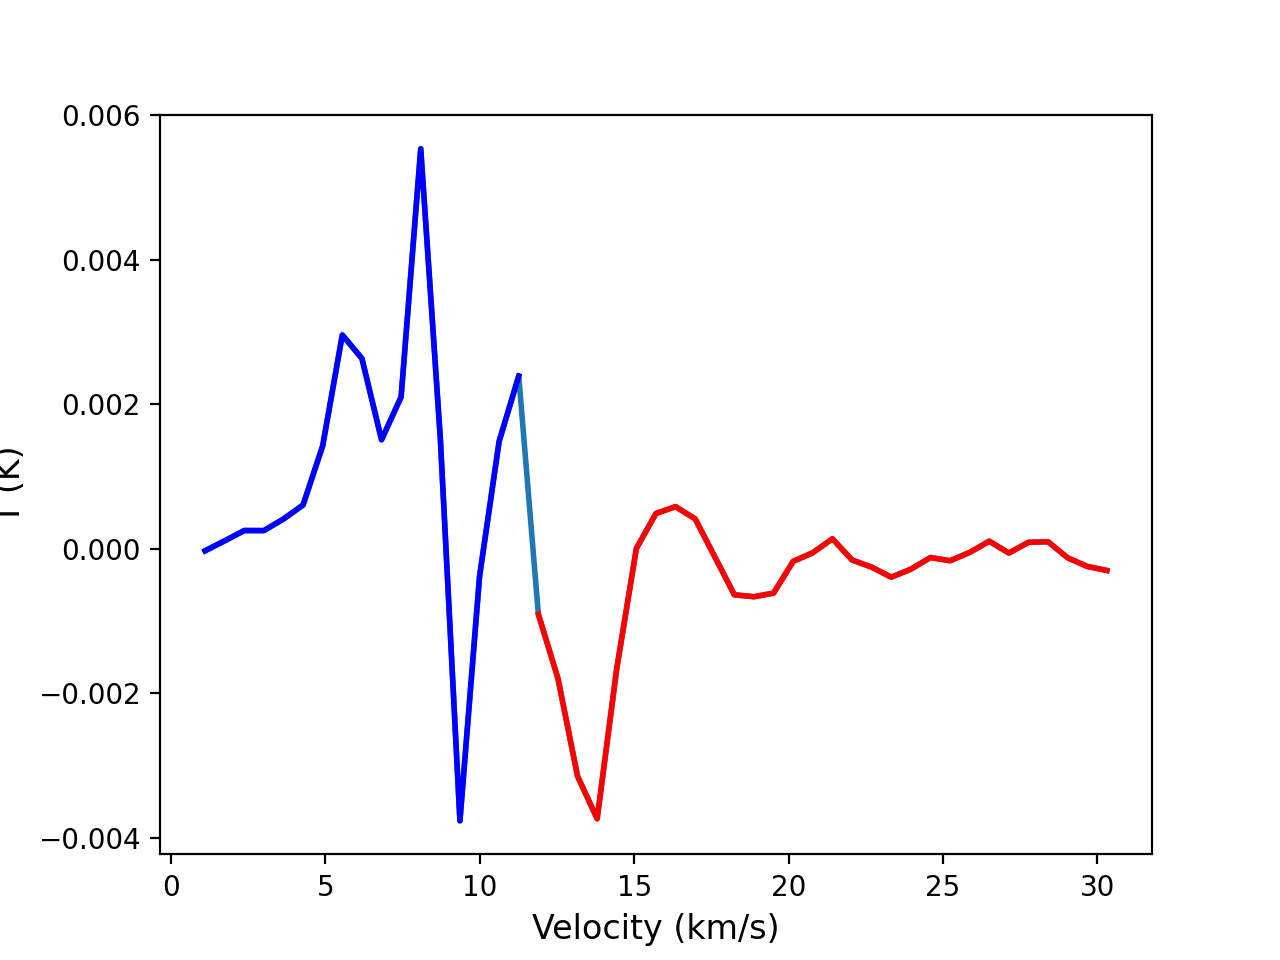

Text(0, 0.5, 'T (K)')

In [7]:
fig, ax = plt.subplots()
spec = np.mean(cube_small, axis = (1,2))
spec_blue = np.mean(cube_kms[Vsys:V1,ybox_min:ybox_max,xbox_min:xbox_max], axis = (1,2))
spec_red = np.mean(cube_kms[V2:Vsys,ybox_min:ybox_max,xbox_min:xbox_max], axis = (1,2))

ax.plot(cube_small.spectral_axis, spec, lw = 2)
ax.plot(cube_kms[Vsys:V1,ybox_min:ybox_max,xbox_min:xbox_max].spectral_axis, spec_blue, lw = 2, color='b')
ax.plot(cube_kms[V2:Vsys,ybox_min:ybox_max,xbox_min:xbox_max].spectral_axis, spec_red, lw = 2, color='r')
ax.set_xlabel("Velocity (km/s)", fontsize = 12)
ax.set_ylabel("T (K)", fontsize = 12)

<IPython.core.display.Javascript object>


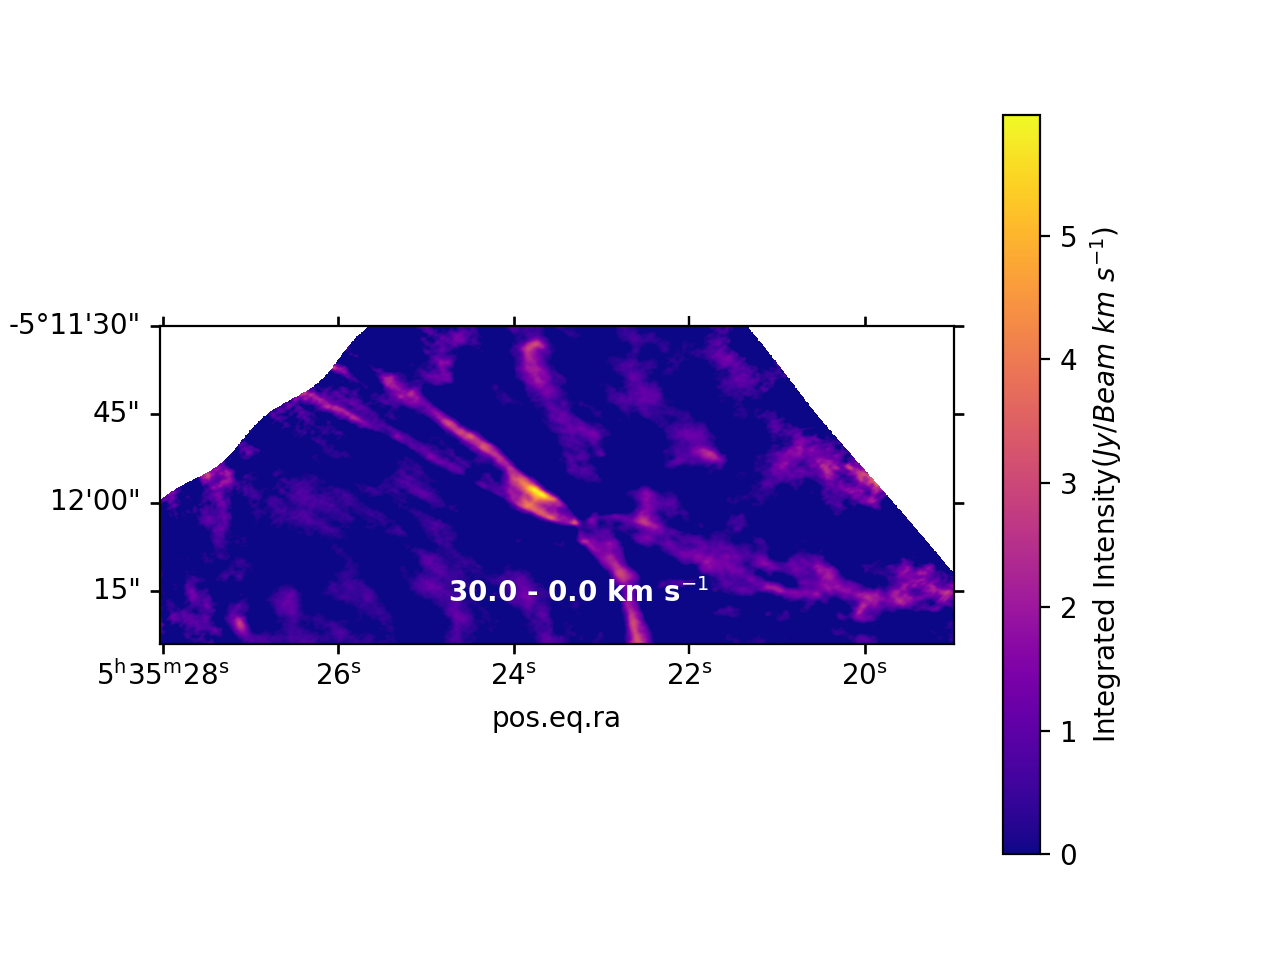

In [8]:
moment_0 = cube_small.moment(order=0) #Want to target velocities b/t 0-7.5 & 12.5-30 km/s
mask = np.isnan(moment_0)
masked_mom0 = np.ma.masked_array(moment_0.value, mask = mask)

fig = plt.figure()
ax = fig.add_subplot(111, projection = moment_0.wcs)
im = ax.imshow(masked_mom0, cmap = "plasma", vmin=0, vmax=np.amax(masked_mom0))
fig.colorbar(im, label = r"Integrated Intensity($Jy/Beam~km~s^{-1}$)")
t = ax.text(350,50, '{:3.1f} - {:3.1f} km s$^{{-1}}$'.format(30, 0),  color='w', size=10, weight="bold") 

/Applications/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


<IPython.core.display.Javascript object>


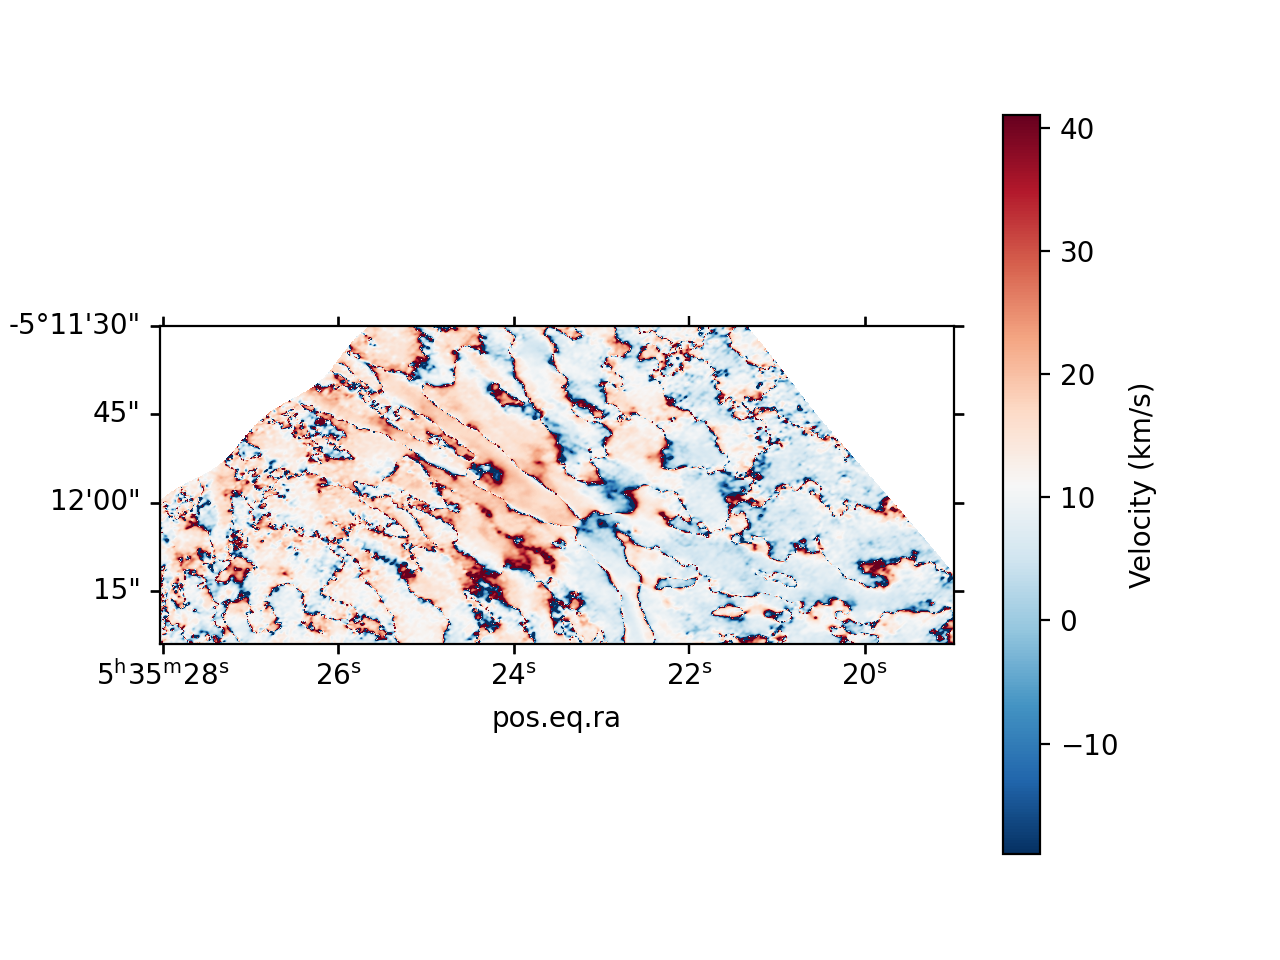

In [9]:
moment_1 = cube_small.moment(order=1).to(u.km/u.s)
masked_vel = np.ma.masked_array(moment_1.value, mask = mask)

fig = plt.figure()
ax = fig.add_subplot(111, projection = moment_0.wcs)
im = ax.imshow(masked_vel, norm = Normalize(vmin = 11-30, vmax = 11+30), cmap = "RdBu_r")
fig.colorbar(im, label = "Velocity (km/s)")

<IPython.core.display.Javascript object>


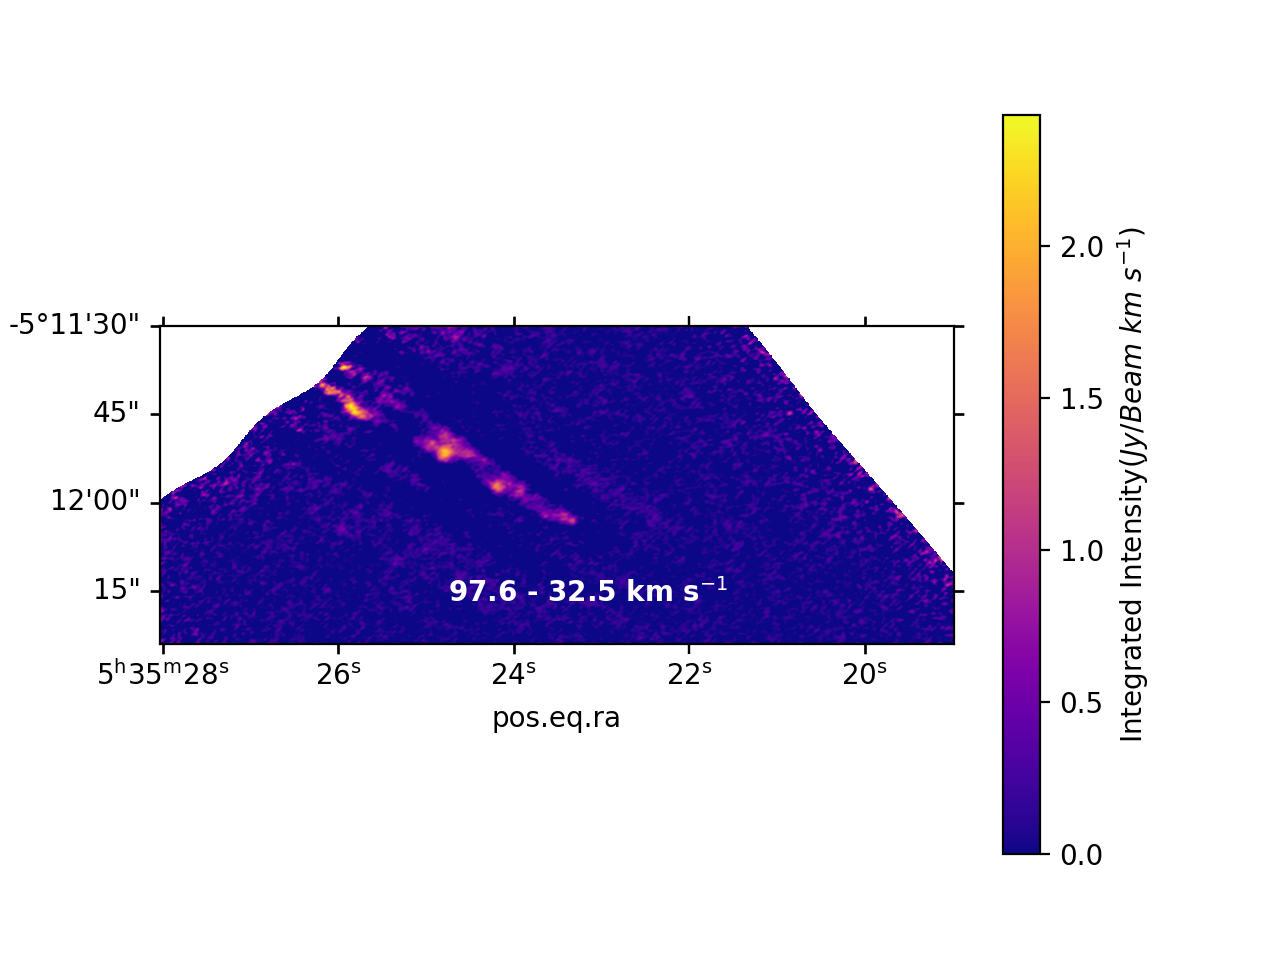

In [10]:
Vel_range = [97.6, 32.5]

jet_m0 = cube_kms[Vel_to_Ch(Vel_range[0]):Vel_to_Ch(Vel_range[1]),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
mask = np.isnan(jet_m0)
masked_mom0 = np.ma.masked_array(jet_m0.value, mask = mask)

fig = plt.figure()
ax = fig.add_subplot(111, projection = moment_0.wcs)
im = ax.imshow(masked_mom0, cmap = "plasma", vmin=0, vmax=np.amax(masked_mom0))
##### Making Color Bar
fig.colorbar(im, label = r"Integrated Intensity($Jy/Beam~km~s^{-1}$)")

t = ax.text(350,50, '{:3.1f} - {:3.1f} km s$^{{-1}}$'.format(Vel_range[0], Vel_range[1]),  color='w', size=10, weight="bold") 

<IPython.core.display.Javascript object>


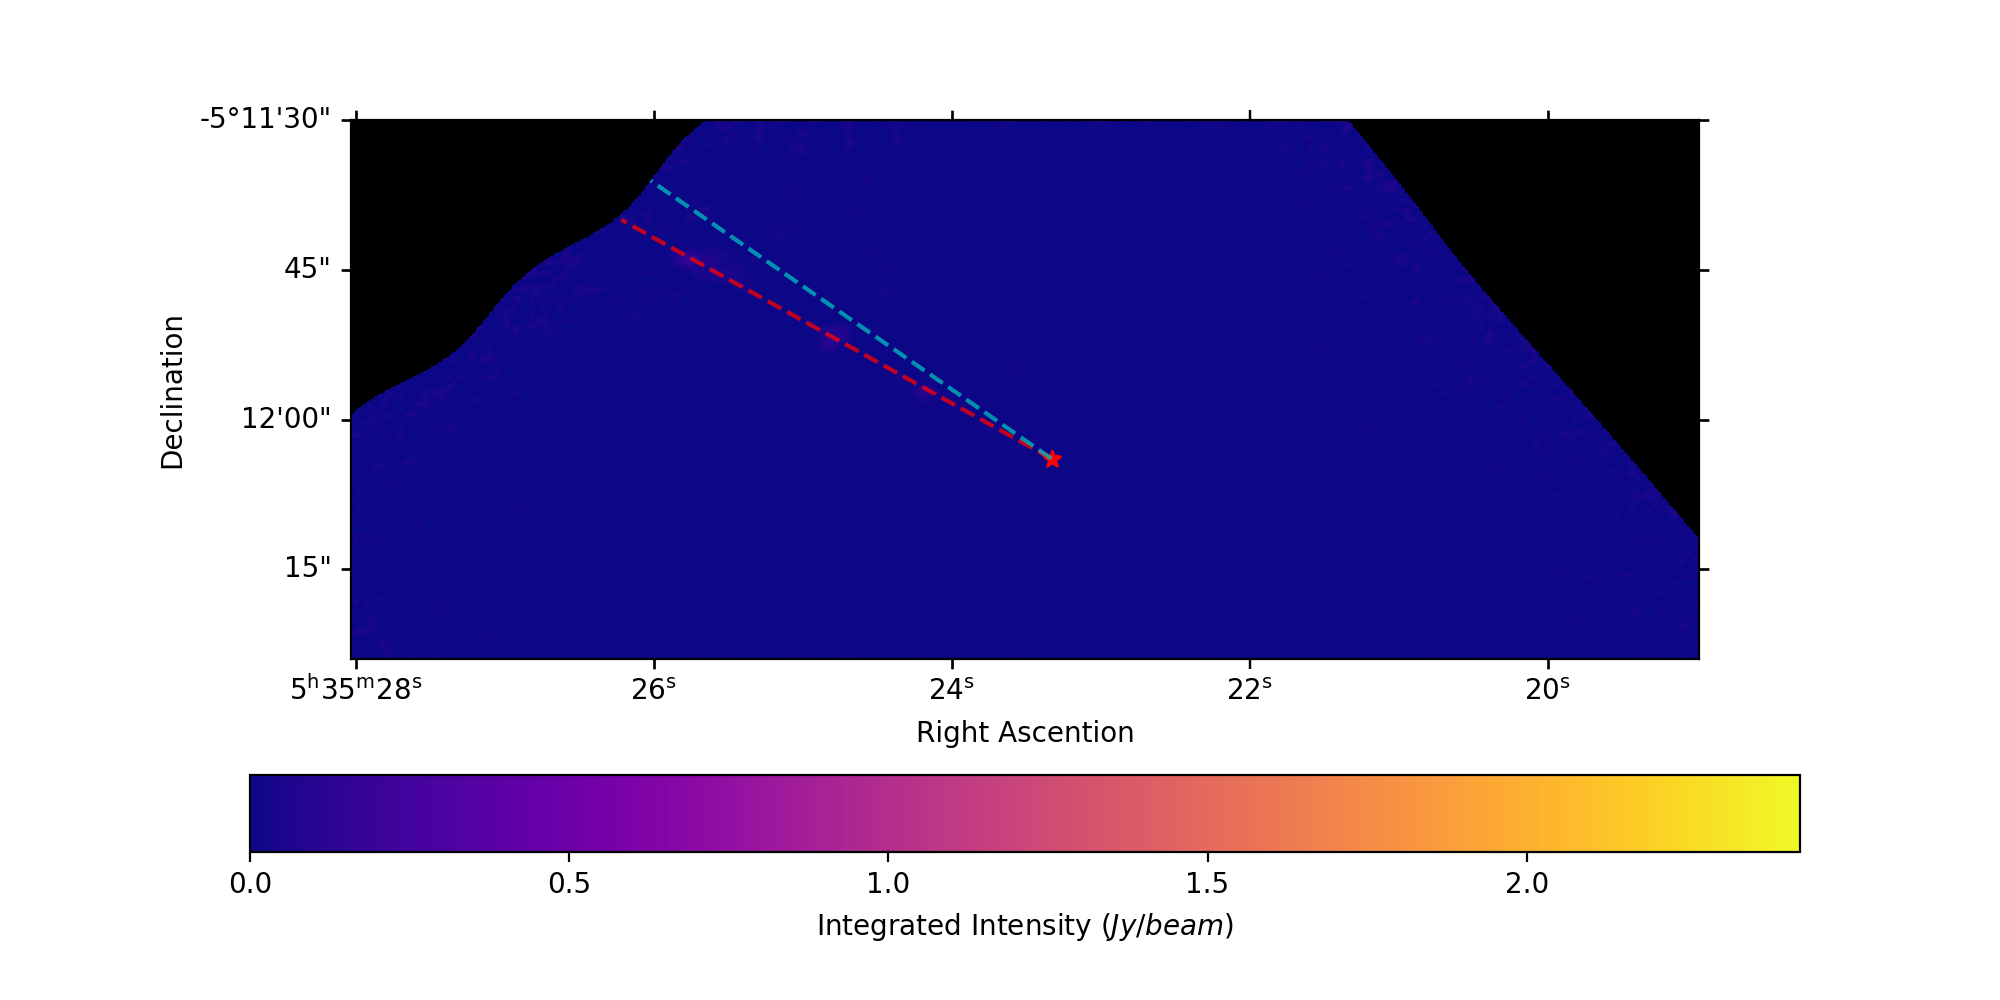

Center pixel of image 482.5 193.0
Center RA/Dec of image 83.84791666666666 -5.199166666666667
Pixel of Star 718 936


In [11]:
# Figure of ~single channel with lines marking projection of jets
jet = 'red'

## CHANNEL RANGES ##
#Channels = [Vel_to_Ch(47),Vel_to_Ch(47)+1] #Blueshifted Jet
#Channels = [Vel_to_Ch(88),Vel_to_Ch(88)+1] #Redshifted Jet
#Channels = [Vel_to_Ch(95),Vel_to_Ch(30)]   #Full Jet Range
#vmax = np.amax(masked_mom0)
#vmax = 0.05
#Title = "OMC2_RedJet_88kms"#"OMC2_BlueJet_47kms"

if jet == 'moment':
    Channels = [Vel_to_Ch(95),Vel_to_Ch(30)]   #Full Jet Range
    Title = "OMC2_Mom0Jets"
    vmax = 2.5
elif jet == 'red':
    Channels = [Vel_to_Ch(88),Vel_to_Ch(88)+1] #Redshifted Jet
    Title = "OMC2_RedJet_88kms"
    vmax = np.amax(masked_mom0)
elif jet == 'blue':
    Channels = [Vel_to_Ch(47),Vel_to_Ch(47)+1] #Redshifted Jet
    Title = "OMC2_BlueJet_47kms"
    vmax = 0.05

#----- NO CHANGES NEEDED BEYOND THIS POINT -----#
jet_m0 = cube_kms[Channels[0]:Channels[1],ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
mask = np.isnan(jet_m0)
masked_mom0 = np.ma.masked_array(jet_m0.value, mask = mask)

def hmspix(hour, mint, sec): # Converts RA hh:mm:ss into pixel of given image
    degree = (hour + (mint + sec/60.)/60.)*360/24
    xpix = np.int(np.shape(masked_mom0)[1]/2 + (hms(hour, mint, sec) - im_cent[0])/cd1)
    return xpix

def dmspix(deg, mint, sec): # Converts Dec dd:mm:ss into degrees
    if deg > 0.:
        degree = deg + (mint + sec/60.)/60.
    else:
        degree = -(-deg + (mint + sec/60.)/60.)
    ypix = np.int(np.shape(masked_mom0)[0]/2 + (dms(deg, mint, sec) - im_cent[1])/cd2)
    return ypix

## MAKING THE FIGURE ##
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection = moment_0.wcs)
cmap = plt.cm.plasma
cmap.set_bad('black',1.)
im = ax.imshow(masked_mom0, cmap = cmap, vmin=0, vmax=vmax)

im_cent = [rabox_min+(rabox_max-rabox_min)/2,decbox_min+(decbox_max-decbox_min)/2]
xstar = hmspix(5,35,23.32) #np.int(np.shape(masked_mom0)[1]/2 + (hms(5,35,23.32) - im_cent[0])/cd1)
ystar = dmspix(-5,12,3.97) #np.int(np.shape(masked_mom0)[0]/2 + (dms(-5,12,3.97) - im_cent[1])/cd2)
ax.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.75) #[x1,x2],[y1,y2]
ax.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.75) #[x1,x2],[y1,y2]
ax.scatter(xstar,ystar, color='r', marker='*')

plt.xlabel('Right Ascention')
plt.ylabel('Declination')
##### Making Contour Bar
#ax = plt.gca()
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("bottom", size="8%", pad=0.5)
#cb = plt.colorbar(im, label = r"Integrated Intensity ($Jy/beam~km~s^{-1}$)", orientation="horizontal")
cb = plt.colorbar(im, label = r"Integrated Intensity ($Jy/beam$)", orientation="horizontal")
#cb.set_label(cbtitle,size=20)
#cb.ax.tick_params(labelsize=15)
#cax.xaxis.set_ticks_position("top")

print('Center pixel of image',np.shape(masked_mom0)[1]/2,np.shape(masked_mom0)[0]/2)
print('Center RA/Dec of image',rabox_min+(rabox_max-rabox_min)/2,decbox_min+(decbox_max-decbox_min)/2)
print('Pixel of Star', Angle_to_Pix(hms(5,35,22), 'ra'),Angle_to_Pix(dms(-5,12,30), 'dec'))

plt.savefig("/Users/jbublitz/Desktop/OMC2_ALMA_Sokar/Figures/"+Title+".png", dpi=200, bbox_inches="tight", overwrite=True)


In [ ]:
fig = plt.figure(figsize=(10,10))
cmap = plt.cm.inferno
cmap.set_bad('black',1.)


ax3 = plt.subplot(313, projection = moment_0.wcs)   #bottom middle
jet_mom0 = cube_kms[Vel_to_Ch(95):(Vel_to_Ch(30)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im3 = ax3.imshow(np.ma.masked_array(jet_mom0.value, mask = np.isnan(jet_mom0)), origin="lower", cmap = cmap, vmin=0)
cb = plt.colorbar(im3, label = r"Integrated Intensity ($Jy/beam$)")
ax3.scatter(xstar,ystar, color='r', marker='*')
t = ax3.text(600,50, '30 - 95 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
plt.xlabel('Right Ascention', fontsize=15)
plt.ylabel('Declination', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = plt.subplot(312, projection = moment_0.wcs, sharex=ax3)   #top right
jet_red = cube_kms[Vel_to_Ch(95):(Vel_to_Ch(75)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im2 = ax2.imshow(np.ma.masked_array(jet_red.value, mask = np.isnan(jet_red)), origin="lower", cmap = cmap, vmin=0)#0.2
ax2.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.75) #[x1,x2],[y1,y2]
ax2.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.75) #[x1,x2],[y1,y2]
ax2.scatter(xstar,ystar, color='r', marker='*')
t = ax2.text(600,50, '75 - 95 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
cb = plt.colorbar(im2)
ax2.tick_params(axis='x', labelbottom=False, labelsize=25)
plt.ylabel(' ')


ax1 = plt.subplot(311, projection = moment_0.wcs, sharex=ax3)   #top left
jet_blue = cube_kms[Vel_to_Ch(60):(Vel_to_Ch(30)),ybox_min:ybox_max,xbox_min:xbox_max].moment(order=0)
im1 = ax1.imshow(np.ma.masked_array(jet_blue.value, mask = np.isnan(jet_blue)), origin="lower", cmap = cmap, vmin=0) #0.05
ax1.plot([hmspix(5,35,23.32),hmspix(5,35,26.2)],[dmspix(-5,12,3.97),dmspix(-5,11,40)],'--r', alpha=0.5) #[x1,x2],[y1,y2]
ax1.plot([hmspix(5,35,23.32),hmspix(5,35,26)],[dmspix(-5,12,3.97),dmspix(-5,11,36)],'--c', alpha=0.5) #[x1,x2],[y1,y2]
ax1.scatter(xstar,ystar, color='r', marker='*')
t = ax1.text(600,50, '30 - 60 km s$^{{-1}}$',  color='w', size=10, weight="bold") 
cb = plt.colorbar(im1)
ax1.tick_params(axis='x', labelbottom=False, labelsize=25)
plt.ylabel(' ')

#plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.1)
#plt.subplot_tool()  # Creates a GUI set of sliders to change spacing
plt.savefig("/Users/jbublitz/Desktop/OMC2_ALMA_Sokar/Figures/OMC2_Jet_trio.pdf", dpi=200, bbox_inches="tight", overwrite=True)
